In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# DEBUG
print(IN_COLAB)

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install grad-cam==1.4.8

In [ ]:
import os
import random
import time
import platform

import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics, model_selection
from skimage import io
from PIL import Image

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models, datasets, utils

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [ ]:
# Verifica se a GPU está disponível
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\nDevice: {0}'.format(DEVICE))


Device: cuda


In [ ]:
!nvidia-smi

Thu Jan  9 22:56:18 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              33W /  70W |   2221MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
if IN_COLAB:
    ds_path = '/content/drive/My Drive/data_set/xkt857dsxk-1/ImagesOriginalSize/'
else:
    ### ds_path = 'data/flowers-recognition/flowers/'
    ds_path = '/home/joao/Datasets/flowers-recognition/flowers/'

EXP_PATH = './exp-02-4/'
if not os.path.exists(EXP_PATH):
    os.makedirs(EXP_PATH)

In [ ]:
# Nomes das classes
class_names = os.listdir(ds_path)
## TODO: Garantir que apenas pastas serão listadas.

# Número de classes. Equivale ao número de subpastas na pasta do dataset.
num_classes = len(class_names)

In [ ]:
# Tamanho do lote (mini-batch)
batch_size = 64
# Taxa de aprendizado
lr = 0.0001
# Mommentum
mm = 0.9
# Número de épocas
epochs = 2 # Usar um valor pequeno durante o desenvolvimento, 2 por exemplo.
# Step size
ss = 10

In [ ]:
ARCH_NAME = 'resnet18' # 'simplenet', 'alexnet', 'resnet18', ...

In [ ]:
class FlowersDataset(Dataset):

    def __init__(self, path_list, label_list, transforms=None):
        self.path_list = path_list
        self.label_list = label_list
        self.transforms = transforms

    def __len__(self):
        return len(self.path_list)

    def __getitem__(self, idx):
        path = self.path_list[idx]
        ### image = io.imread(self.path_list[idx])
        image = Image.open(self.path_list[idx])

        label = self.label_list[idx]

        if self.transforms:
            image = self.transforms(image)

        return (image, label, path)

In [ ]:
# Treinamento. Com data augmentation
data_transforms_train = transforms.Compose([# DATA AUGMENTATION
                                            transforms.RandomHorizontalFlip(p=0.5),
                                            transforms.RandomRotation(degrees=15),
                                            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                            transforms.GaussianBlur(kernel_size=3),
                                            # Resimensiona as imagens para o tamanho da entrada da rede.
                                            ### transforms.Resize(size=(224, 224)),
                                            transforms.RandomResizedCrop(size=224),
                                            transforms.ToTensor(),
                                            # Normalização. Média e desvio padrão do ImageNet.
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                           ])

data_transforms_test = transforms.Compose([# Resimensiona as imagens para o tamanho da entrada da rede.
                                           ### transforms.Resize(size=(224, 224)),
                                           transforms.CenterCrop(size=224),
                                           transforms.ToTensor(),
                                           # Média e desvio padrão do ImageNet.
                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                          ])

In [ ]:
# Lista com todos os caminhos para as imagens e respectivos rótulos
path_list = []
label_list = []

# Itera ao longo das pastas das classes
for class_ in class_names:
    # Lista ordenada dos arquivos (imagens) em cada pasta
    path_list_ = os.listdir(os.path.join(ds_path, class_))
    path_list_.sort()

    # Itera ao longo dos arquivos na pasta atual (classe)
    for path_image in path_list_:
        file_path = os.path.join(ds_path, class_, path_image)
        path_list.append(file_path)
        label_list.append(class_)

In [ ]:
TEST_SIZE = 0.2
VAL_SIZE = 0.2
TRAIN_SIZE = 1. - TEST_SIZE - VAL_SIZE

# Dictionary of index labels
le = preprocessing.LabelEncoder()
le.fit(class_names)
label_list_idx = le.transform(label_list)

# Separa TEST_SIZE do conjuto de completo para TESTES. 1. - TEST_SIZE para treinamento 1.
X_train_, X_test, y_train_, y_test = model_selection.train_test_split(path_list,
                                                                      label_list_idx,
                                                                      test_size=TEST_SIZE,
                                                                      stratify=label_list_idx,
                                                                      random_state=42)

# Separa VAL_SIZE do conjuto de completo para TESTES. (VAL_SIZE / TRAIN_SIZE) do conjunto de treinamento 1.
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_,
                                                                  y_train_,
                                                                  test_size=(VAL_SIZE / TRAIN_SIZE),
                                                                  stratify=y_train_,
                                                                  random_state=42)

# Construindo os datasets usando a classe Dataset personalizado.
train_dataset = FlowersDataset(X_train, y_train, transforms=data_transforms_train)
val_dataset = FlowersDataset(X_val, y_val, transforms=data_transforms_test)
test_dataset = FlowersDataset(X_test, y_test, transforms=data_transforms_test)

# Número de imagens em cada dataset
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

# DEBUG
print(train_size)
print(val_size)
print(test_size)

180
90
68


In [ ]:
# Definindo os dataloaders
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size)

In [ ]:
# Função para desnormalizar e mostrar a imagem
def show_transformed_image(image):
    # Unnormalize the channels
    for t, m, s in zip(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
        t.mul_(s).add_(m)

    np_image = image.numpy()
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

# Caminho das imagens
image_folder = '/content/drive/My Drive/data_set/xkt857dsxk-1/ImagesOriginalSize'

# Transformação para redimensionar e normalizar as imagens
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensiona para 128x128
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Carregar o dataset a partir da pasta de imagens
dataset = datasets.ImageFolder(image_folder, transform=transform)
dataloader_vis = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=64)

# Obter um lote de imagens
items = iter(dataloader_vis)
images, labels = next(items)

# Mostrar as imagens em um grid
grid_image = utils.make_grid(images)
plt.figure(figsize=(20, 20))
show_transformed_image(grid_image)

# Salvar a imagem
EXP_PATH = 'caminho_para_salvar_o_pdf'
os.makedirs(EXP_PATH, exist_ok=True)
plt.savefig(os.path.join(EXP_PATH, 'sample_batch.pdf'))


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
class Net(nn.Module):
    """
    Considering each image having 224 x 224 x 3:

    Input [3, 224, 224]
    Conv1(3, 6, 5) [6, 220, 220]
    Pool(2, 2) 16, 110, 110]
    Conv2(6, 16, 5) [16, 106, 106]
    Pool(2, 2) [16, 53, 53]
    Flatten [44944] (16 x 53 x 53 = 44944)
    Fc1 [120]
    Fc2 [84]
    Fc3 [10]
    """
    def __init__(self, in_channels, num_classes):
        """
        torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0,
                        dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
        """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 53 * 53, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        # conv1(x): Input: [224, 224, 3]. Output: [220, 220, 6].
        x = self.conv1(x)
        x = F.relu(x)
        # pool: Input: [220, 220, 6], Output: [110, 110, 6]
        x = self.pool(x)
        # conv2: Input: [110, 110, 6]. Output: [106, 106, 16].
        x = self.conv2(x)
        x = F.relu(x)
        # pool: Input: [106, 106, 16], Output: [53, 53, 16]
        x = self.pool(x)
        # flatten: Input: [53, 53, 16]. Output: [44944]
        x = torch.flatten(x, 1)
        # fc1: Input: [44944]. Output: [120]
        x = self.fc1(x)
        x = F.relu(x)
        # fc2: Input: [120]. Output: [84]
        x = self.fc2(x)
        x = F.relu(x)
        # fc3: Input: [80]. Output: [num_classes]
        x = self.fc3(x)

        return x


In [ ]:
if ARCH_NAME == 'simplenet':
    # Simple net
    model = Net(224, num_classes)

elif ARCH_NAME == 'alexnet':
    # Pretrainned
    model = models.alexnet(weights='AlexNet_Weights.DEFAULT')
    ### model = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')
    # Altera o número de neurônios na cadama de saída.
    num_ftrs = model.classifier[6].in_features
    ### model.classifier[6] = nn.Linear(4096, num_classes)
    model.classifier[6] = nn.Linear(num_ftrs, num_classes)

elif ARCH_NAME == 'resnet18':
    model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
    ### model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
    # Altera o número de neurônios na cadama de saída.
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

# Include more architectures...
### elif ARCH_NAME == ...


In [ ]:
# Envia o modelo para a GPU
if DEVICE.type == 'cuda':
    model = model.cuda() # Cuda

# Imprime o modelo
print(str(model))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Função de perda
criterion = nn.CrossEntropyLoss()

# Otimizador - SGD
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mm)

# Adjust learning rate
scheduler = lr_scheduler.StepLR(optimizer, step_size=ss)

Epoch 0/1 - TRAIN Loss: 1.0580 TRAIN Acc: 0.4222 - VAL. Loss: 1.0669 VAL. Acc: 0.4778 (73.2850 seconds)
Epoch 1/1 - TRAIN Loss: 1.0551 TRAIN Acc: 0.4611 - VAL. Loss: 1.0572 VAL. Acc: 0.5222 (58.6036 seconds)

Treinamento finalizado. (2m and 11s)
Modelo salvo em: /content/experimento/model.pth


<ipython-input-147-df128f673eae>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(MODEL_PATH, map_location=DEVICE)


Modelo carregado de: /content/experimento/model.pth

Exibindo imagens com Grad-CAM:


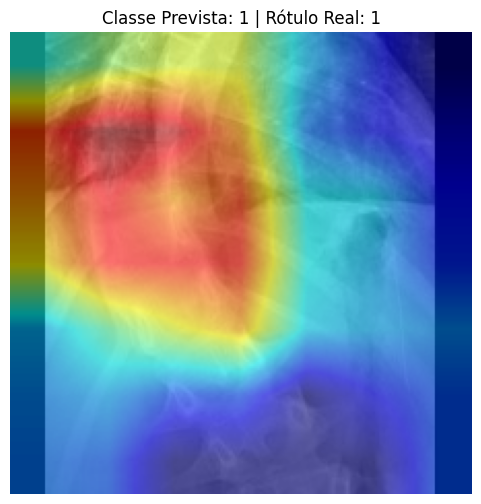

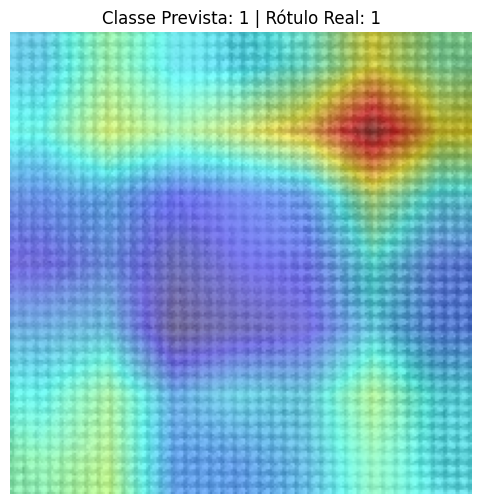

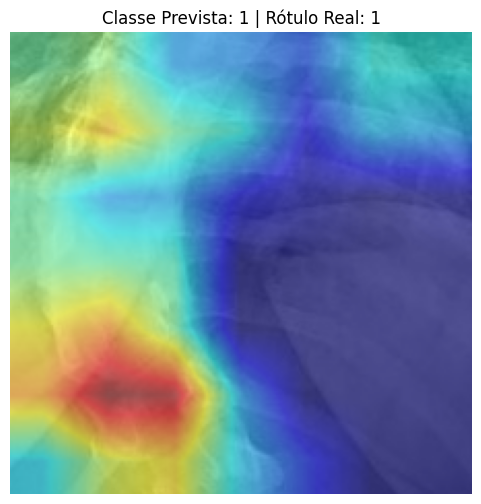

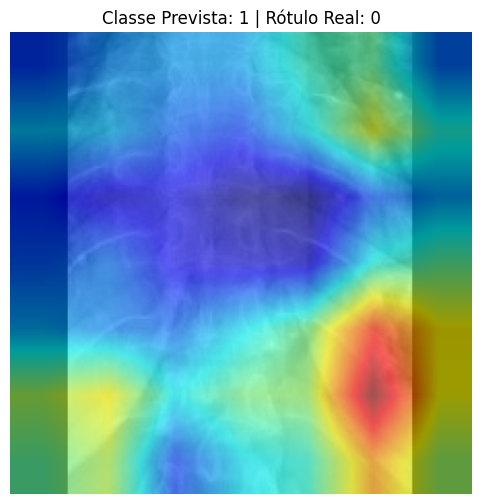

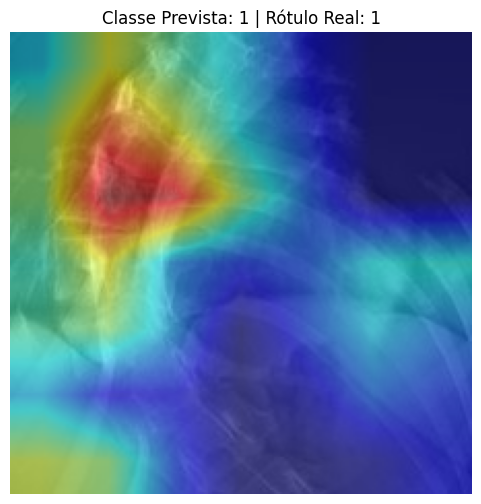

In [ ]:
# Definir dispositivo
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Configurar diretório para salvar modelos e artefatos
BASE_DIR = os.getcwd()
EXP_DIR = os.path.join(BASE_DIR, 'experimento')
os.makedirs(EXP_DIR, exist_ok=True)
MODEL_PATH = os.path.join(EXP_DIR, 'model.pth')

# Função para denormalizar imagens
def denormalize(tensor, mean, std):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Função para salvar o modelo
def save_model(model):
    torch.save(model, MODEL_PATH)
    print(f"Modelo salvo em: {MODEL_PATH}")

# Função para carregar o modelo
def load_model():
    if os.path.exists(MODEL_PATH):
        model = torch.load(MODEL_PATH, map_location=DEVICE)
        model.to(DEVICE)
        model.eval()
        print(f"Modelo carregado de: {MODEL_PATH}")
        return model
    else:
        raise FileNotFoundError(f"O arquivo de modelo {MODEL_PATH} não foi encontrado.")

# Função para aplicar Grad-CAM e visualizar imagens com mapas de calor
def display_gradcam_images(model, dataloader, mean, std, num_images=5):

    target_layer = model.layer4[-1]  # Ajustar conforme a arquitetura do modelo
    cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=DEVICE.type == 'cuda')
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for inputs, labels, *_ in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            for i in range(inputs.size(0)):
                if images_shown >= num_images:
                    return

                img_tensor = inputs[i].unsqueeze(0).to(DEVICE)
                img_tensor.requires_grad_()
                outputs = model(img_tensor)
                class_idx = outputs.argmax(dim=1).item()
                targets = [ClassifierOutputTarget(class_idx)]

                with torch.enable_grad():
                    grayscale_cam = cam(input_tensor=img_tensor, targets=targets)[0, :]

                img_np = denormalize(inputs[i].cpu(), mean, std).permute(1, 2, 0).numpy()
                img_np = np.clip(img_np, 0, 1)
                visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

                plt.figure(figsize=(6, 6))
                plt.imshow(visualization)
                plt.title(f'Classe Prevista: {class_idx} | Rótulo Real: {labels[i].item()}')
                plt.axis('off')
                plt.show()

                images_shown += 1

# Treinamento
train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []
lr_list = []

time_total_start = time.time()

for epoch in range(epochs):
    time_epoch_start = time.time()
    model.train()
    loss_epoch_train, hits_epoch_train = 0.0, 0

    for inputs, labels, *_ in train_dataloader:
        if DEVICE.type == 'cuda':
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        torch.set_grad_enabled(True)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_epoch_train += float(loss.item()) * inputs.size(0)
        hits_epoch_train += torch.sum(preds == labels.data)

    train_loss = loss_epoch_train / train_size
    train_acc = float(hits_epoch_train.double() / train_size)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    model.eval()
    loss_epoch_val, hits_epoch_val = 0.0, 0

    for inputs, labels, *_ in val_dataloader:
        if DEVICE.type == 'cuda':
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        torch.set_grad_enabled(False)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).float()
        loss = criterion(outputs, labels)
        loss_epoch_val += float(loss.item()) * inputs.size(0)
        hits_epoch_val += torch.sum(preds == labels.data)

    scheduler.step()
    lr_list.append(optimizer.param_groups[0]['lr'])
    val_loss = loss_epoch_val / val_size
    val_acc = float(hits_epoch_val.double() / val_size)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    time_epoch = time.time() - time_epoch_start
    print(f'Epoch {epoch}/{epochs - 1} - TRAIN Loss: {train_loss:.4f} TRAIN Acc: {train_acc:.4f} - VAL. Loss: {val_loss:.4f} VAL. Acc: {val_acc:.4f} ({time_epoch:.4f} seconds)')

time_total_train = time.time() - time_total_start
print(f'\nTreinamento finalizado. ({int(time_total_train // 60)}m and {int(time_total_train % 60)}s)')

# Salvar e carregar o modelo
save_model(model)
model = load_model()

# Definir média e desvio padrão
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Exibir Grad-CAM
print("\nExibindo imagens com Grad-CAM:")
display_gradcam_images(model, test_dataloader, mean, std, num_images=5)

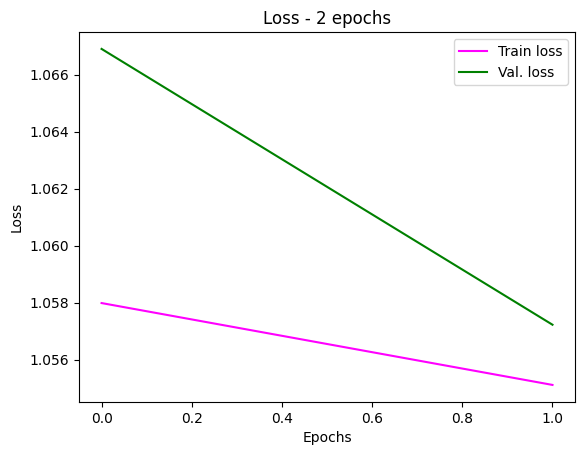

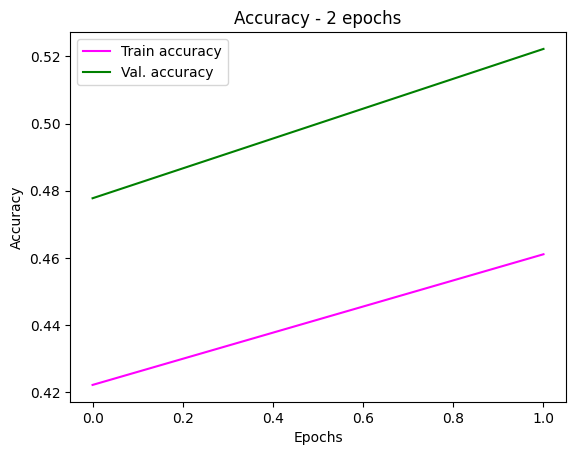

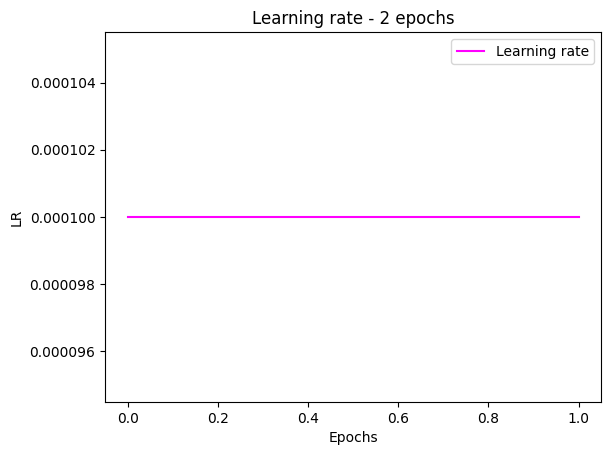

In [ ]:
# Lista com os indices das épocas. [0, 1, ... num_epochs - 1]
epochs_list = []
for i in range(len(train_loss_list)):
    epochs_list.append(i)

# Plot - Loss
plt.figure()
plt.title(f'Loss - {epochs} epochs')
plt.plot(epochs_list, train_loss_list, c='magenta', ls='-', label='Train loss', fillstyle='none')
plt.plot(epochs_list, val_loss_list, c='green', ls='-', label='Val. loss', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.savefig(os.path.join(EXP_PATH, 'loss_history.pdf'))

# Plot - Accuracy
plt.figure()
plt.title(f'Accuracy - {epochs} epochs')
plt.plot(epochs_list, train_acc_list, c='magenta' ,ls='-', label='Train accuracy', fillstyle='none')
plt.plot(epochs_list, val_acc_list, c='green' ,ls='-', label='Val. accuracy', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.savefig(os.path.join(EXP_PATH, 'acc_history.pdf'))

# Plot - LR
plt.figure()
plt.title(f'Learning rate - {epochs} epochs')
plt.plot(epochs_list, lr_list, c='magenta' ,ls='-', label='Learning rate', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('LR')
plt.legend(loc='best')
plt.savefig(os.path.join(EXP_PATH, 'lr_history.pdf'))

In [ ]:
# Lista com as classes reais e classes preditas
true_test_list = []
pred_test_list = []
# Lista com as probabilidades
prob_test_list = []
# lista com os caminhos para as imagens
path_test_list = []

# Iterate along the batches of the TEST SET
for i, (img_list, label_list, path_list) in enumerate(test_dataloader):

    if DEVICE.type == 'cuda':
        img_list = img_list.to(DEVICE)
        label_list = label_list.to(DEVICE)

    # Desabilita o cálculo do gradiente durante validação e testes.
    torch.set_grad_enabled(False)

    # -----> FORWARD
    # Saída do modelo
    outputs = model(img_list)

    # Predição
    preds = torch.argmax(outputs, dim=1)

    # Calcula probabilidades
    # https://discuss.pytorch.org/t/obtain-probabilities-from-cross-entropy-loss/157259
    outputs_prob = nn.functional.softmax(outputs, dim=1)
    ### prob_test_batch = np.asarray(outputs_prob.cpu())
    prob_test_batch = list(outputs_prob.cpu())

    # Classes reais (true) e classes preditas (pred) para este lote.
    if DEVICE.type == 'cuda':
        true_test_batch = list(label_list.cpu())
        pred_test_batch = list(preds.cpu())
    else:
        true_test_batch = list(label_list)
        pred_test_batch = list(preds)

    # Append batch results to the lists
    true_test_list += true_test_batch
    pred_test_list += pred_test_batch

    prob_test_list += prob_test_batch
    path_test_list += path_list


In [ ]:
# Confusion matrix
conf_mat_test = metrics.confusion_matrix(true_test_list, pred_test_list)
print('\nConfusion matrix (test set)')
print(conf_mat_test)

# Classification report - Scikit-learn
class_rep_test = metrics.classification_report(true_test_list,
                                               pred_test_list,
                                               target_names=class_names,
                                               digits=4,
                                               zero_division=0)
print('\nClass. report (test set)')
print(class_rep_test)

# Accuracy
acc_test = metrics.accuracy_score(true_test_list, pred_test_list)
print('\n\nValidation Acc.: {:.4f}'.format(acc_test))


Confusion matrix (test set)
[[ 0 13  1]
 [ 4 34  0]
 [ 3 13  0]]

Class. report (test set)
              precision    recall  f1-score   support

 NormalFinal     0.0000    0.0000    0.0000        14
   ScolFinal     0.5667    0.8947    0.6939        38
  SpondFinal     0.0000    0.0000    0.0000        16

    accuracy                         0.5000        68
   macro avg     0.1889    0.2982    0.2313        68
weighted avg     0.3167    0.5000    0.3878        68



Validation Acc.: 0.5000


In [ ]:
class_rep_path = os.path.join(EXP_PATH, 'classification_report_test.txt')
file_rep = open(class_rep_path, 'w')

file_rep.write('\nTEST. SET:')
file_rep.write('\n\nConfusion matrix:\n')
file_rep.write(str(conf_mat_test))
file_rep.write('\n\nClassification report:\n')
file_rep.write(class_rep_test)
file_rep.write('\n\nAccuracy:\t' + str(acc_test))

file_rep.close()


In [ ]:
# Conjunto de testes
class_rep_path = os.path.join(EXP_PATH, 'class_report_detailed_test.csv')
file_rep = open(class_rep_path, 'w')

print('\n#\tImage path\tTarget\tPrediction\tCorrect?', end='')
file_rep.write('\n#;Image path;Target;Prediction;Correct?')

for class_name in class_names:
    print(f'\t {class_name}', end='')
    file_rep.write(f'\t {class_name}')

for i, (path, true, pred, probs) in enumerate(zip(path_test_list, true_test_list, pred_test_list, prob_test_list)):
    print(f'\n{i} \t {path} \t {true} \t {pred} \t {true==pred}', end='')
    file_rep.write(f'\n{i};{path};{true};{pred};{true==pred}')

    for prob in probs:
        print(f'\t{prob:.4f}', end='')
        file_rep.write(f'\t{prob:.4f}')

file_rep.close()



#	Image path	Target	Prediction	Correct?	 NormalFinal	 ScolFinal	 SpondFinal
0 	 /content/drive/My Drive/data_set/xkt857dsxk-1/ImagesOriginalSize/ScolFinal/N23,S,10,F_1_0.jpg 	 1 	 1 	 True	0.1911	0.5575	0.2515
1 	 /content/drive/My Drive/data_set/xkt857dsxk-1/ImagesOriginalSize/ScolFinal/N13, Rt T and Lt L AIS, M, 14 Yrs.jpg 	 1 	 1 	 True	0.2402	0.5589	0.2009
2 	 /content/drive/My Drive/data_set/xkt857dsxk-1/ImagesOriginalSize/ScolFinal/N72, Rt TAIS, F, 17 Yrs.jpg 	 1 	 1 	 True	0.2827	0.4811	0.2361
3 	 /content/drive/My Drive/data_set/xkt857dsxk-1/ImagesOriginalSize/NormalFinal/N55,N,33,F_1_0.jpg 	 0 	 1 	 False	0.2348	0.5450	0.2203
4 	 /content/drive/My Drive/data_set/xkt857dsxk-1/ImagesOriginalSize/ScolFinal/N49, Rt TAIS, F, 14 Yrs.jpg 	 1 	 1 	 True	0.3179	0.4276	0.2545
5 	 /content/drive/My Drive/data_set/xkt857dsxk-1/ImagesOriginalSize/SpondFinal/n39,s,49,f_1004_3.jpg 	 2 	 1 	 False	0.2588	0.5077	0.2335
6 	 /content/drive/My Drive/data_set/xkt857dsxk-1/ImagesOriginalSize/Spond